In [1]:
%load_ext autoreload
%autoreload 1
%aimport ECGDataset
%aimport Models
%aimport Net
%aimport train_test_validat
%aimport ecg_plot
%aimport logger
import ECGDataset 
import Models 
import Net
from train_test_validat import *
from self_attention import *
import matplotlib.pyplot as plt
import ecg_plot

import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import random
import pandas as pd

import time
import math
import os
import gc
import random


import sys
import logger


from torch.utils.tensorboard import SummaryWriter


time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime()) 
model_path = './model/'+time_str
log_path = './logs/'+  time_str

EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

BATCH_SIZE = 160

FOLDS = 5
EPOCHS = 100  
PATIENCE = 10
LR = 0.01
    
ALLDataset = ECGDataset.ECG_Dataset_Init('/workspace/data/Preprocess_HTN/data_like_pxl//',filter_age= 18,filter_department='外科',rebuild_flage=False)
    


cuda:0
105375
              HTN        NHTN   
   nums       1871      103504  


            orginal            QC         
   nums      105375          66163        
reset size 15
delete size 99
              HTN        NHTN   
   nums       1289      64775   


            orginal   filtered department 
   nums      66064           13896        
              HTN        NHTN   
   nums       1289      12607   


            orginal     removed ages NaN  
   nums      13896           13896        
              HTN        NHTN   
   nums       1289      12607   


            orginal      filtered ages    
   nums      13896           13520        
              HTN        NHTN   
   nums       1273      12247   


            orginal   removed diagnose NaN
   nums      13520           13517        
              HTN        NHTN   
   nums       1282      12235   


ERR labels num: 17


            orginal    removed duplicated 
   nums      13517           11604        
            

In [2]:
def seed_torch(seed=1029):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	# torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	# torch.backends.cudnn.benchmark = False 
	# torch.backends.cudnn.deterministic = True

In [3]:
seed_torch(2022)

In [2]:
# all_dataset =pd.concat([ALLDataset.testDf,ALLDataset.tvDf],axis=0,ignore_index=True)
all_dataset = ALLDataset.INFOsDf.copy()
all_dataset = all_dataset.sample(frac=1).reset_index(drop=True) 
print(all_dataset)

         num name  ages gender  diagnose  department      ID  \
0      17283  林少钦    22      男         0    胃肠肿瘤外科病房  830275   
1      12181  曾晓琦    37      女         0      乳腺外科病房  829830   
2        175  刘冬英    63      女         0      乳腺外科病房  864345   
3       7657   席华    38      女         0      乳腺外科病房  537082   
4       1642  冯丽梅    38      女         0      乳腺外科病房  840608   
...      ...  ...   ...    ...       ...         ...     ...   
11599   2923  卓泗水    70      男         0  耳鼻喉头颈外科一病区  288771   
11600  20438  段训勇    57      男         0  耳鼻喉头颈外科一病区  840592   
11601   2525  纪越好    59      女         0      心脏外科病房  884152   
11602  22545  熊友先    66      女         0     泌尿外科一病区  804052   
11603   3054  许丽珠    52      女         0      心脏外科病房  901852   

                      date                     ecgFN q_sum  
0      2020-09-11 12:05:20    20-17283_22-1_NHTN.npy     0  
1      2020-09-22 09:17:53    20-12181_37-0_NHTN.npy     0  
2      2021-04-23 08:57:48    21-4-175_63-0_NHTN

In [3]:
all_dataset = ALLDataset.INFOsDf.copy()
all_dataset = all_dataset.sample(frac=1).reset_index(drop=True) 
# test_dataset = ECGDataset.ECG_Dataset('/workspace/data/Preprocess_HTN/data_like_pxl//',ALLDataset.testDf)  # type: ignore  
test_size = len(all_dataset[(all_dataset['diagnose']==1)])//FOLDS
test_pair_Df = pair_HTN(all_dataset[(all_dataset['diagnose']==1)].iloc[:test_size],all_dataset[(all_dataset['diagnose']==0)],Range_max = 15,shuffle=True)
test_dataset = ECGDataset.ECG_Dataset('/workspace/data/Preprocess_HTN/data_like_pxl//',test_pair_Df)  # type: ignore

tv_Df = ((all_dataset).drop(index= test_pair_Df.index)).reset_index(drop=True)

In [8]:
test_size*2

518

In [7]:
tv_Df

,num,name,ages,gender,diagnose,department,ID,date,ecgFN,q_sum
0,312,吕素月,56,女,0,乳腺外科病房,855230,2021-02-26 15:33:42,21-2-312_56-0_NHTN.npy,0
1,675,何子房,71,男,0,普外科二病区,840209,2020-11-17 17:09:17,20-675_71-1_NHTN.npy,0
2,3434,赖丽娜,38,女,0,乳腺外科病房,856579,2021-03-05 09:32:19,21-3-3434_38-0_NHTN.npy,0
3,1353,李新瑛,66,女,0,乳腺外科病房,870756,2021-06-02 09:50:21,21-6-1353_66-0_NHTN.npy,0
4,14381,李琳冰,51,女,0,乳腺外科病房,772517,2020-01-31 11:35:35,20-14381_51-0_NHTN.npy,0
...,...,...,...,...,...,...,...,...,...,...
11081,15318,杨元福,67,男,0,泌尿外科一病区,809840,2020-04-28 15:43:24,20-15318_67-1_NHTN.npy,0
11082,2993,陈老野,67,男,0,胃肠肿瘤外科病房,851844,2021-02-01 15:21:43,21-2-2993_67-1_NHTN.npy,0
11083,1876,林素华,53,女,0,普外科二病区,847531,2021-01-04 17:40:53,21-1-1876_53-0_NHTN.npy,0
11084,7344,宋建莲,43,女,0,结直肠肿瘤外科病房,812208,2020-05-18 10:15:48,20-7344_43-0_NHTN.npy,0


In [6]:
ALLDataset.INFOsDf

,num,name,ages,gender,diagnose,department,ID,date,ecgFN,q_sum
110,100,林加顺,37,男,1,,,,00-100_37-1_HTN.npy,0
20937,4,叶忠权,20,男,1,,,,00-4_20-1_HTN.npy,0
20885,495,陈志勇,47,男,1,,,,00-495_47-1_HTN.npy,0
20897,496,苏文明,30,男,1,,,,00-496_30-1_HTN.npy,0
20910,497,黄志伟,57,男,1,,,,00-497_57-1_HTN.npy,0
...,...,...,...,...,...,...,...,...,...,...
51929,3273,史庆戈,57,男,0,普外科一病区,829210,2020-09-08 00:22:40,20-3273_57-1_NHTN.npy,0
51861,32679,郑章明,58,男,0,肝胆胰血管外科病房,802508,2020-03-06 11:21:07,20-32679_58-1_NHTN.npy,0
51920,32731,郑美芳,53,女,0,心脏外科病房,808569,2020-05-22 08:37:38,20-32731_53-0_NHTN.npy,0
51959,32767,郑艳玲,38,女,0,乳腺外科病房,804311,2020-03-19 17:09:03,20-32767_38-0_NHTN.npy,0


In [4]:
for i in range(5):
    tv_Df = (ALLDataset.tvDf.copy()).reset_index(drop=True)
    tv_Df = tv_Df.sample(frac=1)
    print(tv_Df.index)

Int64Index([3310, 2075, 6528, 2095, 3939,  661, 2070, 6889, 5157, 6722,
            ...
            4240,   24, 2066, 5047, 6384, 5809, 4720,  173, 1244, 4989],
           dtype='int64', length=7089)
Int64Index([5356, 2346, 3609,  365, 1960, 6120, 1700,   94, 3228, 7021,
            ...
            3016, 1556, 5127,  702,  963, 2974,  718, 3596, 5108, 2094],
           dtype='int64', length=7089)
Int64Index([5417, 2505, 2792, 6836, 3608, 7078, 1843, 6354, 4119, 3257,
            ...
            3599, 5360, 2600, 1866, 5383,  771, 4158, 5695, 2698, 1456],
           dtype='int64', length=7089)
Int64Index([6542, 4156, 6033,  947, 3619, 2643, 4229, 3688, 6604, 4930,
            ...
             528, 6069, 4434, 2245, 3226, 4564, 4450, 5065, 6528, 5982],
           dtype='int64', length=7089)
Int64Index([2152, 7031, 4633,  251, 1727, 6507, 6671, 3895, 3109, 5649,
            ...
            2532, 6362, 1737, 6173, 2656, 3265, 3458, 2837, 2527, 1477],
           dtype='int64', length=7089)


In [6]:
seed_torch(2022)
for i in range(5):
    tv_Df = (ALLDataset.tvDf.copy()).reset_index(drop=True)
    tv_Df = tv_Df.sample(frac=1)
    print(tv_Df.index)

Int64Index([3310, 2075, 6528, 2095, 3939,  661, 2070, 6889, 5157, 6722,
            ...
            4240,   24, 2066, 5047, 6384, 5809, 4720,  173, 1244, 4989],
           dtype='int64', length=7089)
Int64Index([5356, 2346, 3609,  365, 1960, 6120, 1700,   94, 3228, 7021,
            ...
            3016, 1556, 5127,  702,  963, 2974,  718, 3596, 5108, 2094],
           dtype='int64', length=7089)
Int64Index([5417, 2505, 2792, 6836, 3608, 7078, 1843, 6354, 4119, 3257,
            ...
            3599, 5360, 2600, 1866, 5383,  771, 4158, 5695, 2698, 1456],
           dtype='int64', length=7089)
Int64Index([6542, 4156, 6033,  947, 3619, 2643, 4229, 3688, 6604, 4930,
            ...
             528, 6069, 4434, 2245, 3226, 4564, 4450, 5065, 6528, 5982],
           dtype='int64', length=7089)
Int64Index([2152, 7031, 4633,  251, 1727, 6507, 6671, 3895, 3109, 5649,
            ...
            2532, 6362, 1737, 6173, 2656, 3265, 3458, 2837, 2527, 1477],
           dtype='int64', length=7089)


In [5]:
for i in range(5):
    validate_pair_Df = pair_HTN(tv_Df[(tv_Df['diagnose']==1)],tv_Df[(tv_Df['diagnose']==0)],Range_max = 15,shuffle=True)
    print(validate_pair_Df.index)

Int64Index([ 986,  951,  497,  197,  963,  459,  825,  309,  936,  133,
            ...
            5060, 3387, 3470, 4632, 2399, 2787, 6289, 2799, 2300, 5742],
           dtype='int64', length=1984)
Int64Index([ 257,   12,  386,  583,  674,  471,  316,  795,  786,  479,
            ...
            3020, 6677, 3331, 3710, 7001, 5116, 6236, 4661, 6518, 5703],
           dtype='int64', length=1984)
Int64Index([ 869,  125,  920,  458,  400,  129,  913,  318,  646,  797,
            ...
            6085, 3104, 4482, 2352, 2697, 3243, 1196, 3861, 6084, 2013],
           dtype='int64', length=1984)
Int64Index([ 898,  287,  379,  397,  262,  239,  245,  991,  792,  365,
            ...
            2676, 6374, 6132, 4160, 1772, 1654, 2976, 7017, 2222, 3338],
           dtype='int64', length=1984)
Int64Index([ 103,  394,  529,  326,  640,  524,  635,  557,  177,  468,
            ...
            1596, 6700, 4600, 1120, 6598, 6342, 2346, 5395, 3769, 1110],
           dtype='int64', length=1984)


In [6]:
for i in range(5):
    validate_pair_Df = pair_HTN(tv_Df[(tv_Df['diagnose']==1)],tv_Df[(tv_Df['diagnose']==0)],Range_max = 15,shuffle=True)
    print(validate_pair_Df.index)

Int64Index([ 986,  951,  497,  197,  963,  459,  825,  309,  936,  133,
            ...
            5060, 3387, 3470, 4632, 2399, 2787, 6289, 2799, 2300, 5742],
           dtype='int64', length=1984)
Int64Index([ 257,   12,  386,  583,  674,  471,  316,  795,  786,  479,
            ...
            3020, 6677, 3331, 3710, 7001, 5116, 6236, 4661, 6518, 5703],
           dtype='int64', length=1984)
Int64Index([ 869,  125,  920,  458,  400,  129,  913,  318,  646,  797,
            ...
            6085, 3104, 4482, 2352, 2697, 3243, 1196, 3861, 6084, 2013],
           dtype='int64', length=1984)
Int64Index([ 898,  287,  379,  397,  262,  239,  245,  991,  792,  365,
            ...
            2676, 6374, 6132, 4160, 1772, 1654, 2976, 7017, 2222, 3338],
           dtype='int64', length=1984)
Int64Index([ 103,  394,  529,  326,  640,  524,  635,  557,  177,  468,
            ...
            1596, 6700, 4600, 1120, 6598, 6342, 2346, 5395, 3769, 1110],
           dtype='int64', length=1984)


In [3]:
test_dataloader = Data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False,pin_memory=True)

In [48]:
test_infors = (test_dataset.infos.copy()).reset_index()

In [49]:
test_infors

,index,num,name,ages,gender,department,diagnose,ID,date,ecgFN,q_sum
0,79936,160,冯淑敏,66,女,心血管内科病房,1,850842,2021-12-31 10:12:20,21-12-160_66-0_NHTN.npy,0
1,75121,1585,林燕凌,38,男,内分泌糖尿病科病房,1,882295,2021-10-20 16:07:56,21-10-1585_38-1_NHTN.npy,0
2,76244,2593,谢丽华,58,女,内分泌糖尿病科病房,1,888458,2021-10-13 17:43:17,21-10-2593_58-0_NHTN.npy,0
3,94421,152,关光定,58,男,干部保健一科二区,1,780777,2021-05-26 11:14:31,21-5-152_58-1_NHTN.npy,0
4,71360,221,刘纯香,51,女,乳腺外科病房,1,849400,2021-01-15 10:32:39,21-1-221_51-0_NHTN.npy,0
...,...,...,...,...,...,...,...,...,...,...,...
609,85974,1970,林欣欣,42,男,泌尿外科一病区,0,469789,2021-03-05 09:04:32,21-3-1970_42-1_NHTN.npy,0
610,75278,1726,柯财茂,62,男,普外科一病区,0,505870,2021-10-30 19:40:32,21-10-1726_62-1_NHTN.npy,0
611,95223,422,吴丽敏,44,女,乳腺外科病房,0,836698,2021-05-21 11:08:42,21-5-422_44-0_NHTN.npy,0
612,80834,2410,王天雄,58,男,胃肠肿瘤外科病房,0,879252,2021-12-11 09:18:05,21-12-2410_58-1_NHTN.npy,0


In [53]:
y_ture = []
y_pred = []
y_output = [] 
for i,data in enumerate(test_dataloader,0):
    inputs,labels = data[0],data[1]
    outputs = torch.nn.functional.one_hot(labels,2)
    pred = labels
    y_ture.extend((pred.to('cpu').detach().numpy()).tolist())
    y_pred.extend((pred.to('cpu').detach().numpy()).tolist())
    y_output.extend((outputs.to('cpu').detach().numpy()).tolist())            

In [54]:
ouputs_Df = pd.DataFrame(np.array(y_output),columns=["out0","out1"])
preds_Df = pd.DataFrame(np.array(y_pred),columns=["pred"])
target_Df = pd.DataFrame(np.array(y_ture),columns=["target"])

In [40]:
ouputs_Df

,Out0,Out1
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
609,1,0
610,1,0
611,1,0
612,1,0


In [55]:
test_infors = pd.concat([test_infors,target_Df,preds_Df,ouputs_Df],axis = 1)

In [56]:
test_infors.to_csv()

,index,num,name,ages,gender,department,diagnose,ID,date,ecgFN,q_sum,target,pred,out0,out1
0,79936,160,冯淑敏,66,女,心血管内科病房,1,850842,2021-12-31 10:12:20,21-12-160_66-0_NHTN.npy,0,1,1,0,1
1,75121,1585,林燕凌,38,男,内分泌糖尿病科病房,1,882295,2021-10-20 16:07:56,21-10-1585_38-1_NHTN.npy,0,1,1,0,1
2,76244,2593,谢丽华,58,女,内分泌糖尿病科病房,1,888458,2021-10-13 17:43:17,21-10-2593_58-0_NHTN.npy,0,1,1,0,1
3,94421,152,关光定,58,男,干部保健一科二区,1,780777,2021-05-26 11:14:31,21-5-152_58-1_NHTN.npy,0,1,1,0,1
4,71360,221,刘纯香,51,女,乳腺外科病房,1,849400,2021-01-15 10:32:39,21-1-221_51-0_NHTN.npy,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,85974,1970,林欣欣,42,男,泌尿外科一病区,0,469789,2021-03-05 09:04:32,21-3-1970_42-1_NHTN.npy,0,0,0,1,0
610,75278,1726,柯财茂,62,男,普外科一病区,0,505870,2021-10-30 19:40:32,21-10-1726_62-1_NHTN.npy,0,0,0,1,0
611,95223,422,吴丽敏,44,女,乳腺外科病房,0,836698,2021-05-21 11:08:42,21-5-422_44-0_NHTN.npy,0,0,0,1,0
612,80834,2410,王天雄,58,男,胃肠肿瘤外科病房,0,879252,2021-12-11 09:18:05,21-12-2410_58-1_NHTN.npy,0,0,0,1,0


In [62]:
list__ = [0.7785016286644951, 0.6840390879478827, 0.6970684039087948]
(np.array(list__)).mean()

0.7198697068403909

In [93]:
INFOsDf = ALLDataset.INFOsDf.copy()

In [116]:
df1 = INFOsDf[(INFOsDf['diagnose'] == 1)] #
df2 = INFOsDf[(~(INFOsDf.duplicated(subset=['ID'],keep=False)))&(INFOsDf['diagnose'] == 0)]
df3 = INFOsDf[((INFOsDf.duplicated(subset=['ID'],keep=False)))&(INFOsDf['diagnose'] == 0)].drop_duplicates(subset=['ID'],keep='last')

print(len(df1)+len(df2)+len(df3))

11659


In [114]:
INFOsDf[(INFOsDf.duplicated(subset=['ID'],keep=False))&(INFOsDf['diagnose'] == 0)].drop_duplicates(subset=['ID'],keep='last')

,num,name,ages,gender,diagnose,department,ID,date,ecgFN,q_sum
77477,3688,黄贝,54,女,0,心脏外科病房,889669,2021-10-20 09:17:28,21-10-3688_54-0_NHTN.npy,0
77300,3527,黄反水,48,男,0,心脏外科病房,888836,2021-10-17 10:56:35,21-10-3527_48-1_NHTN.npy,0
77249,3481,魏丽丽,28,女,0,普外科一病区,888717,2021-10-10 22:29:24,21-10-3481_28-0_NHTN.npy,0
83388,491,吴安龙,45,男,0,泌尿外科一病区,894878,2021-12-28 09:17:24,21-12-491_45-1_NHTN.npy,0
83208,4516,黄瑞禄,64,男,0,结直肠肿瘤外科病房,856208,2021-12-15 09:08:38,21-12-4516_64-1_NHTN.npy,0
...,...,...,...,...,...,...,...,...,...,...
52130,32920,郑雨,46,男,0,泌尿外科一病区,823667,2020-08-02 09:59:09,20-32920_46-1_NHTN.npy,0
51971,32778,郑芳平,38,男,0,耳鼻喉头颈外科一病区,800660,2020-02-13 10:22:52,20-32778_38-1_NHTN.npy,0
51988,32793,郑荣华,41,男,0,普外科一病区(胃肠外科一科),796668,2020-01-04 10:51:35,20-32793_41-1_NHTN.npy,0
52095,3288,史秋芬,66,女,0,结直肠肿瘤外科病房,803425,2020-08-25 10:05:07,20-3288_66-0_NHTN.npy,0


In [3]:
tv_Df = (ALLDataset.tvDf.copy()).reset_index(drop=True)
print(tv_Df.iloc[0][0])
tv_Df = tv_Df.sample(frac=1)#Shuffle before k-fold train
tv_Lables = np.array(tv_Df['diagnose'].tolist())# type: ignore 
strKFold = StratifiedKFold(n_splits=FOLDS, shuffle=False)  # shuffle 参数用于确定在分类前是否对数据进行打乱清洗
for train_index, val_index in strKFold.split(np.zeros(len(tv_Lables)),tv_Lables):
    train_infos = tv_Df.iloc[train_index].reset_index(drop=True) # type: ignore        
    val_infos = tv_Df.iloc[val_index].reset_index(drop=True) # type: ignore  
    print(len(train_infos[train_infos['diagnose'] == 0]),len(train_infos[train_infos['diagnose'] == 1]))
    print(len(val_infos[val_infos['diagnose'] == 0]),len(val_infos[val_infos['diagnose'] == 1]))
    # print(val_infos[val_infos['diagnose'] == 1])

100
4877 794
1220 198
4877 794
1220 198
4878 793
1219 199
4878 793
1219 199
4878 794
1219 198


In [4]:
import augmenters

In [3]:
x = torch.zeros((2,12,5000))
y = torch.zeros((2,1))

In [10]:
augmenters.gen_baseline_wander(x,500,prob=torch.rand(1))


tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[-1.0111e-03, -1.1979e-03, -5.4929e-04,  ..., -1.7903e-04,
           3.8441e-04, -9.3332e-04],
         [ 6.7130e-03,  6.6709e-03,  6.6287e-03,  ..., -3.9060e-02,
          -3.9039e-02, -3.9017e-02],
         [ 4.4092e-02,  4.3898e-02,  4.3702e-02,  ..., -2.8833e-01,
          -2.8813e-01, -2.8794e-01],
         ...,
         [ 4.7884e-02,  4

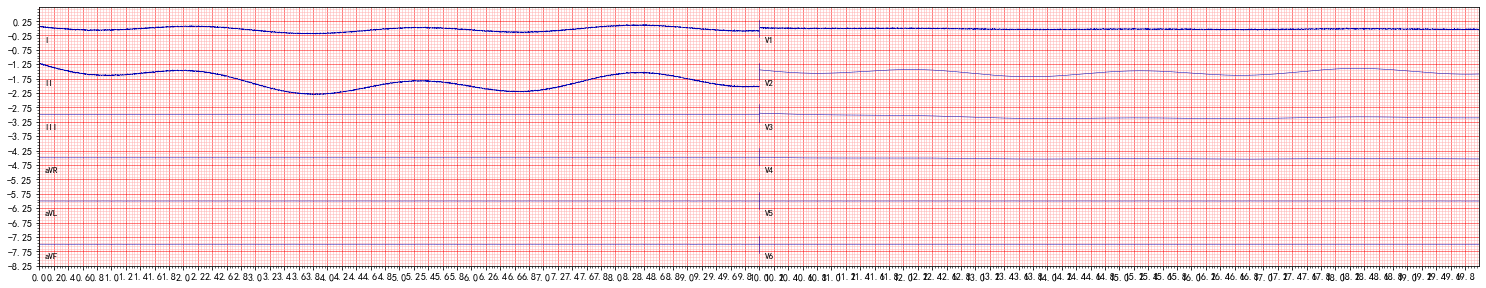

In [16]:
ecg_plot.plot(augmenters.gen_baseline_wander(x,500,prob=torch.rand(1))[0],500,'',columns=2,row_height= 3,show_grid=True,show_separate_line=True)  # type: ignore

In [19]:
testdf = ALLDataset.INFOsDf.copy()

In [3]:
df1 = testdf[testdf['ID']=='']
df1 = df1.sort_values(by=['diagnose'], ascending=[False]) #按照诊断排序，HTN在前
df1[df1.duplicated(subset=['name','ages','gender'])]

,num,name,ages,gender,diagnose,department,ID,date,ecgFN,q_sum
21045,508,李添福,56,男,1,,,,00-508_56-1_HTN.npy,0
21057,509,李添福,56,男,1,,,,00-509_56-1_HTN.npy,0
21400,537,陈庆荣,78,男,1,,,,00-537_78-1_HTN.npy,0
21497,545,陈瑞慧,36,女,1,,,,00-545_36-0_HTN.npy,0
19957,419,林志海,42,男,1,,,,00-419_42-1_HTN.npy,1
...,...,...,...,...,...,...,...,...,...,...
18506,300,万秋菊,72,女,1,,,,00-300_72-0_HTN.npy,10
18530,302,万秋菊,72,女,1,,,,00-302_72-0_HTN.npy,0
18554,304,万秋菊,72,女,1,,,,00-304_72-0_HTN.npy,1
18601,308,范志洪,36,男,1,,,,00-308_36-1_HTN.npy,0


In [24]:
df2 = testdf[~(testdf['ID']=='')]
df2 = df2.sort_values(by=['diagnose'], ascending=[False]) #按照诊断排序，HTN在前
df2_0 = df2[df2['diagnose']==0] #所有非高血压
df2_1 = df2[df2['diagnose']==1] #所有高血压

duplicated_index = df2_0[[True if i in df2_1['ID'].tolist() else False for i in df2_0['ID']]].index
df2.loc[duplicated_index,'diagnose'] = 1


In [13]:
df2 = df2.sort_values(by=['diagnose'], ascending=[False]) #按照诊断排序，HTN在前
df2_0 = df2[df2['diagnose']==0] #所有非高血压
df2_1 = df2[df2['diagnose']==1] #所有高血压

duplicated_index = df2_0[[True if i in df2_1['ID'].tolist() else False for i in df2_0['ID']]].index

<AxesSubplot:>

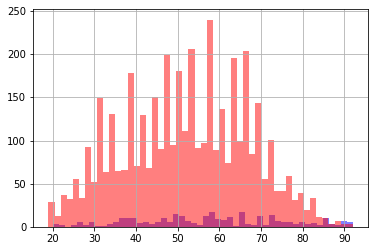

In [5]:
ALLDataset.testDf[(ALLDataset.testDf['diagnose']==1)]['ages'].hist(color='b', alpha=0.5, bins=50)
ALLDataset.testDf[(ALLDataset.testDf['diagnose']==0)]['ages'].hist(color='r', alpha=0.5, bins=50)

<AxesSubplot:>

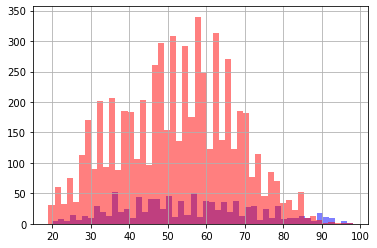

In [6]:
ALLDataset.tvDf[(ALLDataset.tvDf['diagnose']==1)]['ages'].hist(color='b', alpha=0.5, bins=50)
ALLDataset.tvDf[(ALLDataset.tvDf['diagnose']==0)]['ages'].hist(color='r', alpha=0.5, bins=50)

<AxesSubplot:ylabel='Density'>

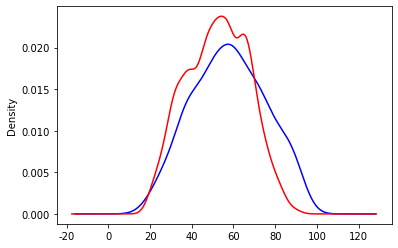

In [7]:
ALLDataset.testDf[(ALLDataset.testDf['diagnose']==1)]['ages'].plot(kind='kde',color='b')
ALLDataset.testDf[(ALLDataset.testDf['diagnose']==0)]['ages'].plot(kind='kde',color='r')

<AxesSubplot:ylabel='Density'>

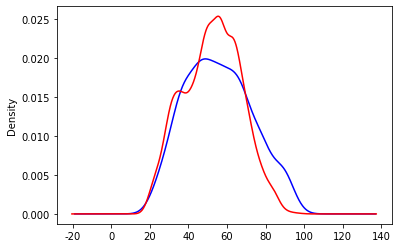

In [8]:
ALLDataset.tvDf[(ALLDataset.tvDf['diagnose']==1)]['ages'].plot(kind='kde',color='b')
ALLDataset.tvDf[(ALLDataset.tvDf['diagnose']==0)]['ages'].plot(kind='kde',color='r')

In [6]:
def pair_HTN(INPUT_HTN_Df,INPUT_NHTN_Df,Range_max = 10,shuffle = False):
    HTN_Df = ((INPUT_HTN_Df).copy())
    NHTN_Df = ((INPUT_NHTN_Df).copy())#即抽即删,抽出一条删一条
    if(shuffle): #打乱
        HTN_Df = (HTN_Df.sample(frac=1))
        NHTN_Df = (NHTN_Df.sample(frac=1))
    # pair_Df = INFOs_df = pd.DataFrame(index=range(len(HTN_Df)*2),columns=HTN_Df.columns)   #所有的HNT和抽取出来的NHTN都存放入其中
    pair_Df = HTN_Df #先将所有HTN存放入其中
    index = len(HTN_Df)
    for info in HTN_Df.itertuples():
        age = info.ages
        gender = info.gender
        candidate_NHTN_Df = pd.DataFrame()
        
        for Range in range(1,Range_max): # 在 ±Range_max 范围内搜寻ages，且gender相同的NHTN样本
            candidate_NHTN_Df = NHTN_Df[(NHTN_Df['ages']>age-Range)&(NHTN_Df['ages']<age+Range)&(NHTN_Df['gender']==gender)]
            if(len(candidate_NHTN_Df) > 0):
                break
        
        if(len(candidate_NHTN_Df)<1):# ±Range_max 范围内都没有，那么就从所有NHTN样本（删除掉之前被抽到的）中抽一个
            print("lack sample like :",info)
            candidate_NHTN_Df = NHTN_Df
        NHTN_data_buff = candidate_NHTN_Df.sample(n=1) #从candida中随机抽样一个
        # pair_Df.iloc[index] = NHTN_data_buff.iloc[0]
        pair_Df = pair_Df.append(NHTN_data_buff)
        # print(age,',',NHTN_data_buff['ages'])
        # print(NHTN_data_buff.index)
        NHTN_Df = NHTN_Df.drop(index= (NHTN_data_buff.index))
        index = index +1
    return pair_Df
        
            

In [7]:
testsize = len(ALLDataset.tvDf[(ALLDataset.tvDf['diagnose']==1)])//5
# print(testsize)
for i in range(5):
    All_df = ALLDataset.tvDf.copy()    
    validate_pair_Df = pair_HTN(All_df[(All_df['diagnose']==1)].iloc[testsize*i:testsize*i+testsize],All_df[(All_df['diagnose']==0)],Range_max = 15)
    validate_dataset = ECGDataset.ECG_Dataset('/workspace/data/Preprocess_HTN/data_like_pxl//',validate_pair_Df)
    All_df = All_df.drop(index= validate_pair_Df.index)    #删掉validate_pair_Df
    train_pair_Df_ = pair_HTN(All_df[(All_df['diagnose']==1)],All_df[(All_df['diagnose']==0)],Range_max = 15)
    
    

100%|██████████| 340/340 [00:12<00:00, 26.56it/s]


In [9]:
Model = Net.MLBFNet(2)

In [10]:
x,y = validate_dataset.__getitem__(0)
Model(x)

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
from scipy.signal import butter, lfilter

In [ ]:
filter_lowcut = 1.0
filter_highcut = 47.0
filter_order = 1

In [ ]:

def bandpass_filter(data, lowcut, highcut, signal_freq, filter_order):
        """
        Method responsible for creating and applying Butterworth filter.
        :param deque data: raw data
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :return array: filtered data
        """
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(filter_order, [low, high], btype="band")
        y = lfilter(b, a, data)
        return y

In [ ]:
X,Y = test_dataset.__getitem__(0)
ecg_plot.plot(X/100,500,(test_dataset.info(0)).tolist(),columns=2,row_height= 8,show_grid=True,show_separate_line=True)  # type: ignore

In [ ]:
X_filtet = bandpass_filter(X, lowcut=filter_lowcut, highcut=filter_highcut, signal_freq=500, filter_order=filter_order)# type: ignore  

In [ ]:
ecg_plot.plot(X_filtet/100,500,(test_dataset.info(0)).tolist(),columns=2,row_height= 8,show_grid=True,show_separate_line=True)  # type: ignore